# SEDD for Masked RNA-seq Prediction

This notebook demonstrates how to use Score-Entropy Discrete Diffusion (SEDD) for masked gene expression prediction on single-cell RNA-seq data.

## Overview

SEDD is a discrete diffusion model that learns to predict masked tokens. For RNA-seq data:
- Gene expression values are discretized into bins
- The model learns to predict masked gene expression values
- This can be used for imputation, denoising, and generating synthetic cells

In [1]:
import sys
sys.path.insert(0, '..')
# writing the address shifting lines for the parent directory. 

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. Generate Synthetic Data

We'll create synthetic single-cell RNA-seq data with cell type-specific expression patterns.

In [3]:
# this needs to be translated into a better kind of cell dataset - ideally from a downloaded h5ad. 

from sedd.data import create_synthetic_rnaseq, RNASeqDataset, train_val_split

# Create synthetic data
expression, cell_types, gene_names = create_synthetic_rnaseq(
    num_cells=2000,
    num_genes=200,
    num_cell_types=5,
    sparsity=0.7,
    seed=42
)

print(f'Expression shape: {expression.shape}')
print(f'Cell types: {np.unique(cell_types)}')
print(f'Sparsity: {(expression == 0).mean():.2%}')

Expression shape: (2000, 200)
Cell types: [0 1 2 3 4]
Sparsity: 69.90%


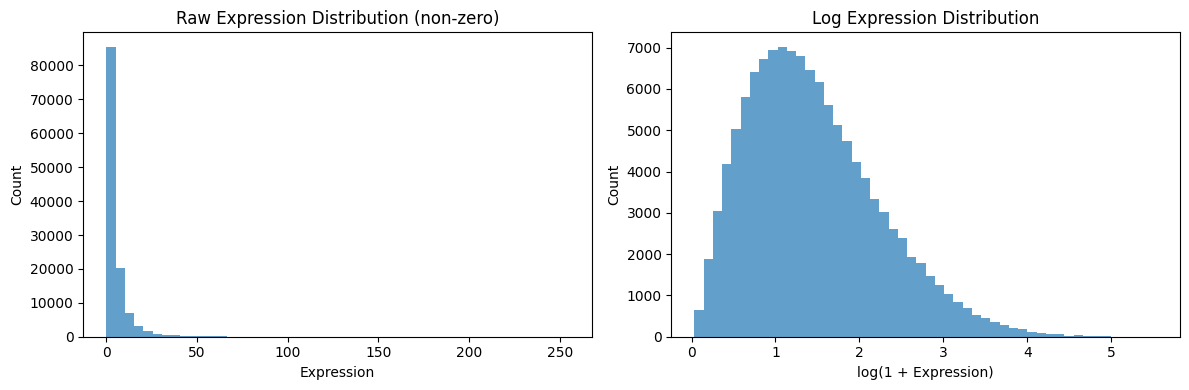

In [ ]:
# Visualize expression distribution
# exploring the dataset. 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Raw expression distribution (non-zero values)
non_zero = expression[expression > 0]
axes[0].hist(non_zero.flatten(), bins=50, alpha=0.7)
axes[0].set_xlabel('Expression')
axes[0].set_ylabel('Count')
axes[0].set_title('Raw Expression Distribution (non-zero)')

# Log expression
axes[1].hist(np.log1p(non_zero.flatten()), bins=50, alpha=0.7)
axes[1].set_xlabel('log(1 + Expression)')
axes[1].set_ylabel('Count')
axes[1].set_title('Log Expression Distribution')

plt.tight_layout()
plt.show()

## 2. Create Dataset and DataLoaders

The `RNASeqDataset` automatically discretizes continuous expression values into bins.

In [5]:
# Create dataset with discretization
NUM_BINS = 100  # Number of expression bins

dataset = RNASeqDataset(
    expression=expression,
    gene_names=gene_names,
    cell_labels=cell_types,
    num_bins=NUM_BINS,
    discretization_method='log_uniform'
)

print(f'Dataset size: {len(dataset)}')
print(f'Number of genes: {dataset.num_genes}')
print(f'Number of bins: {dataset.num_bins}')

# Split into train/val
train_dataset, val_dataset = train_val_split(dataset, val_fraction=0.1, seed=42)
print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}')

Dataset size: 2000
Number of genes: 200
Number of bins: 100
Train size: 1800, Val size: 200


In [ ]:
# Visualize discretized expression
sample = dataset[0]
print(f'Sample shape: {sample.shape}')
print(f'Discretized values range: [{sample.min()}, {sample.max()}]')

plt.figure(figsize=(10, 3))
plt.hist(sample.numpy(), bins=NUM_BINS, alpha=0.7)
plt.xlabel('Bin Index')
plt.ylabel('Count')
plt.title('Discretized Expression for One Cell')
plt.show()

In [6]:
# Create dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')

Number of training batches: 29
Number of validation batches: 4


In [ ]:
print(train_dataset[0])

## 3. Create SEDD Model

We'll use a small transformer model suitable for this demo.

In [7]:
from sedd.model import SEDDTransformerSmall
from sedd.graph import AbsorbingGraph
from sedd.noise import LogLinearNoise

# Create model components
NUM_GENES = dataset.num_genes
VOCAB_SIZE = NUM_BINS + 1  # +1 for mask token

model = SEDDTransformerSmall(
    num_genes=NUM_GENES,
    num_bins=NUM_BINS,
    hidden_dim=128,
    num_layers=4,
    num_heads=4,
    dropout=0.1
).to(device)

graph = AbsorbingGraph(num_states=VOCAB_SIZE)
noise = LogLinearNoise(eps=1e-3)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f'Model parameters: {num_params:,}')

Model parameters: 1,768,064


## 4. Train the Model

We'll train for a few epochs to demonstrate the training loop.

In [8]:
from sedd.trainer import SEDDTrainer

# Create trainer
trainer = SEDDTrainer(
    model=model,
    graph=graph,
    noise=noise,
    device=device,
    gradient_clip=1.0
)

# Train for a few epochs (use more epochs for better results)
NUM_EPOCHS = 20
MASK_RATIO = 0.15  # Fraction of genes to mask during training

history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    mask_ratio=MASK_RATIO,
    log_interval=50,
    val_interval=1
)

Epoch 1/20: 100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


Epoch 1: train_loss=4.4485, val_loss=4.0596


Epoch 2/20: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it, loss=2.4993]


Epoch 2: train_loss=3.0444, val_loss=1.9323


Epoch 3/20: 100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


Epoch 3: train_loss=1.8938, val_loss=1.8502


Epoch 4/20: 100%|██████████| 29/29 [00:29<00:00,  1.03s/it, loss=1.8857]


Epoch 4: train_loss=1.8329, val_loss=1.8137


Epoch 5/20: 100%|██████████| 29/29 [00:38<00:00,  1.33s/it]


Epoch 5: train_loss=1.8190, val_loss=1.8379


Epoch 6/20: 100%|██████████| 29/29 [00:42<00:00,  1.45s/it, loss=1.8185]


Epoch 6: train_loss=1.8217, val_loss=1.8148


Epoch 7/20: 100%|██████████| 29/29 [00:44<00:00,  1.54s/it, loss=1.8184]


Epoch 7: train_loss=1.8244, val_loss=1.8008


Epoch 8/20: 100%|██████████| 29/29 [00:44<00:00,  1.55s/it]


Epoch 8: train_loss=1.8064, val_loss=1.8066


Epoch 9/20: 100%|██████████| 29/29 [00:44<00:00,  1.54s/it, loss=1.7749]


Epoch 9: train_loss=1.8117, val_loss=1.8153


Epoch 10/20: 100%|██████████| 29/29 [00:44<00:00,  1.55s/it]


Epoch 10: train_loss=1.8141, val_loss=1.8272


Epoch 11/20: 100%|██████████| 29/29 [00:45<00:00,  1.56s/it, loss=1.7835]


Epoch 11: train_loss=1.8144, val_loss=1.8177


Epoch 12/20: 100%|██████████| 29/29 [00:43<00:00,  1.51s/it]


Epoch 12: train_loss=1.8138, val_loss=1.8251


Epoch 13/20: 100%|██████████| 29/29 [00:45<00:00,  1.56s/it, loss=1.8148]


Epoch 13: train_loss=1.8166, val_loss=1.8328


Epoch 14/20: 100%|██████████| 29/29 [00:45<00:00,  1.56s/it, loss=1.8286]


Epoch 14: train_loss=1.8191, val_loss=1.8231


Epoch 15/20: 100%|██████████| 29/29 [00:44<00:00,  1.54s/it]


Epoch 15: train_loss=1.8219, val_loss=1.8127


Epoch 16/20: 100%|██████████| 29/29 [00:44<00:00,  1.53s/it, loss=1.7774]


Epoch 16: train_loss=1.8070, val_loss=1.8078


Epoch 17/20: 100%|██████████| 29/29 [00:44<00:00,  1.54s/it]


Epoch 17: train_loss=1.7851, val_loss=1.8347


Epoch 18/20: 100%|██████████| 29/29 [00:44<00:00,  1.53s/it, loss=1.7704]


Epoch 18: train_loss=1.7883, val_loss=1.8021


Epoch 19/20: 100%|██████████| 29/29 [00:43<00:00,  1.51s/it, loss=1.7576]


Epoch 19: train_loss=1.7734, val_loss=1.7981


Epoch 20/20: 100%|██████████| 29/29 [00:44<00:00,  1.54s/it]


Epoch 20: train_loss=1.7779, val_loss=1.8029


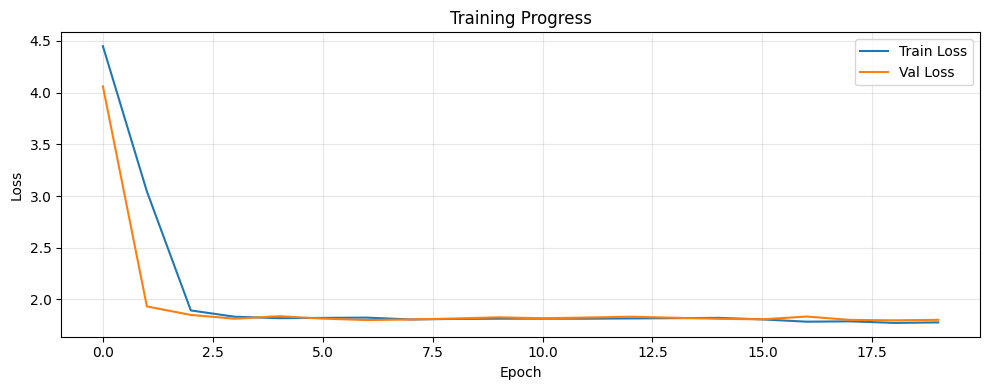

In [9]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(history['train_loss'], label='Train Loss')
ax.plot(history['val_loss'], label='Val Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Test Masked Prediction (Imputation)

Now we'll test the model's ability to predict masked gene expression values.

In [10]:
from sedd.sampling import impute_masked, EulerSampler

# Get a batch of test samples
test_batch = next(iter(val_loader)).to(device)
print(f'Test batch shape: {test_batch.shape}')

# Create random mask (mask 20% of genes)
mask_ratio = 0.2
mask = torch.rand_like(test_batch.float()) < mask_ratio

print(f'Masked positions: {mask.sum().item()} / {mask.numel()}')

Test batch shape: torch.Size([64, 200])
Masked positions: 2551 / 12800


In [11]:
# Impute masked values
imputed = impute_masked(
    model=model,
    graph=graph,
    noise=noise,
    x=test_batch,
    mask=mask,
    sampler='euler',
    num_steps=50,
    temperature=1.0,
    show_progress=True
)

Sampling: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


In [12]:
# Evaluate imputation accuracy
# Get original values at masked positions
original_masked = test_batch[mask]
predicted_masked = imputed[mask]

# Calculate accuracy (exact match)
accuracy = (original_masked == predicted_masked).float().mean().item()
print(f'Exact match accuracy: {accuracy:.2%}')

# Calculate mean absolute error in bin space
mae = (original_masked - predicted_masked).abs().float().mean().item()
print(f'Mean Absolute Error (bins): {mae:.2f}')

# Calculate within-k accuracy
for k in [1, 3, 5, 10]:
    within_k = ((original_masked - predicted_masked).abs() <= k).float().mean().item()
    print(f'Within {k} bins: {within_k:.2%}')

Exact match accuracy: 51.67%
Mean Absolute Error (bins): 11.73
Within 1 bins: 51.94%
Within 3 bins: 53.16%
Within 5 bins: 54.80%
Within 10 bins: 61.00%


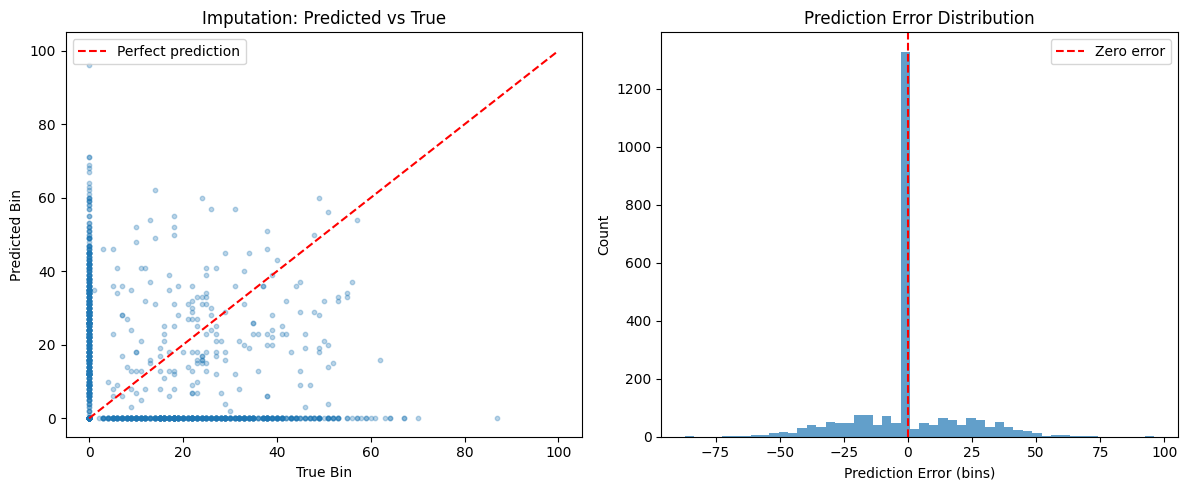

In [13]:
# Visualize predictions vs ground truth
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
axes[0].scatter(
    original_masked.cpu().numpy(),
    predicted_masked.cpu().numpy(),
    alpha=0.3,
    s=10
)
axes[0].plot([0, NUM_BINS], [0, NUM_BINS], 'r--', label='Perfect prediction')
axes[0].set_xlabel('True Bin')
axes[0].set_ylabel('Predicted Bin')
axes[0].set_title('Imputation: Predicted vs True')
axes[0].legend()

# Error distribution
errors = (predicted_masked - original_masked).cpu().numpy()
axes[1].hist(errors, bins=50, alpha=0.7)
axes[1].axvline(0, color='r', linestyle='--', label='Zero error')
axes[1].set_xlabel('Prediction Error (bins)')
axes[1].set_ylabel('Count')
axes[1].set_title('Prediction Error Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Visualize Single Cell Imputation

Let's look at imputation for a single cell in detail.

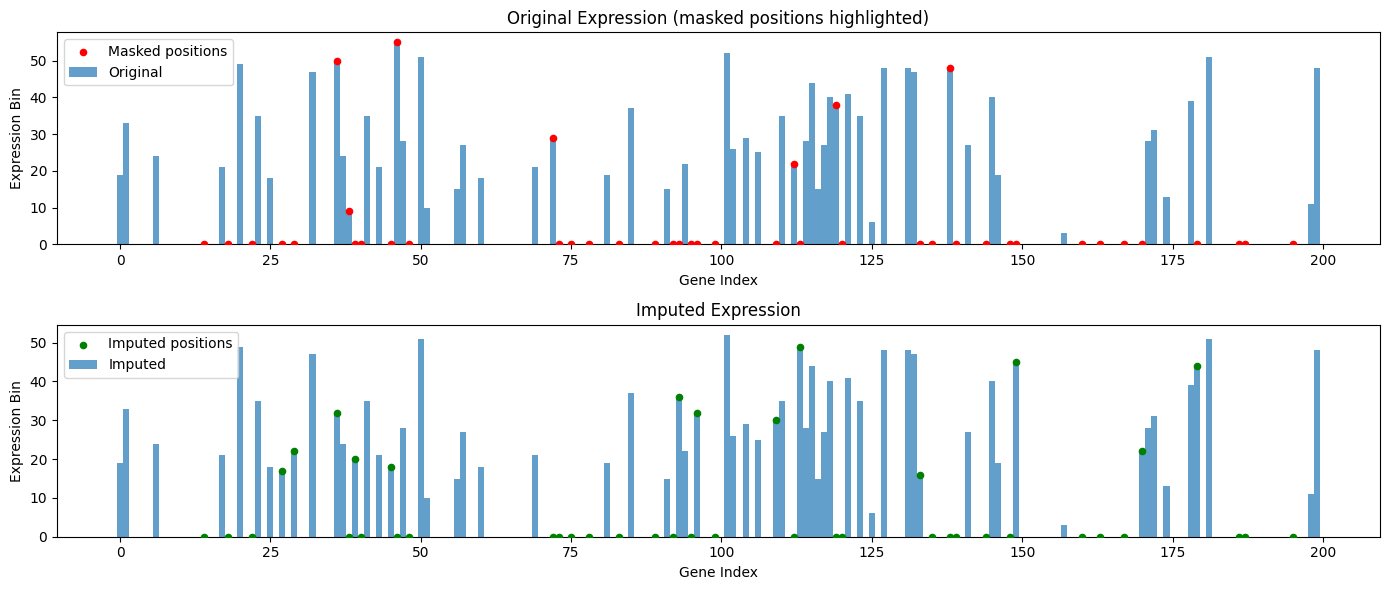

Cell 0 - Accuracy: 55.81%, MAE: 13.26 bins


In [14]:
# Single cell example
cell_idx = 0
original_cell = test_batch[cell_idx].cpu().numpy()
imputed_cell = imputed[cell_idx].cpu().numpy()
cell_mask = mask[cell_idx].cpu().numpy()

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Plot expression profiles
gene_indices = np.arange(len(original_cell))

# Original
axes[0].bar(gene_indices, original_cell, alpha=0.7, label='Original', width=1.0)
axes[0].scatter(gene_indices[cell_mask], original_cell[cell_mask], 
                c='red', s=20, zorder=5, label='Masked positions')
axes[0].set_xlabel('Gene Index')
axes[0].set_ylabel('Expression Bin')
axes[0].set_title('Original Expression (masked positions highlighted)')
axes[0].legend()

# Imputed
axes[1].bar(gene_indices, imputed_cell, alpha=0.7, label='Imputed', width=1.0)
axes[1].scatter(gene_indices[cell_mask], imputed_cell[cell_mask], 
                c='green', s=20, zorder=5, label='Imputed positions')
axes[1].set_xlabel('Gene Index')
axes[1].set_ylabel('Expression Bin')
axes[1].set_title('Imputed Expression')
axes[1].legend()

plt.tight_layout()
plt.show()

# Calculate cell-specific accuracy
cell_acc = (original_cell[cell_mask] == imputed_cell[cell_mask]).mean()
cell_mae = np.abs(original_cell[cell_mask] - imputed_cell[cell_mask]).mean()
print(f'Cell {cell_idx} - Accuracy: {cell_acc:.2%}, MAE: {cell_mae:.2f} bins')

## 7. Generate New Cells (De Novo Generation)

We can also use SEDD to generate entirely new cell expression profiles by starting from all masked tokens.

In [15]:
from sedd.sampling import EulerSampler

# Create sampler for generation
sampler = EulerSampler(
    model=model,
    graph=graph,
    noise=noise,
    num_steps=100,
    device=device,
    temperature=1.0
)

# Generate from all-masked starting point
num_generate = 5
x_init = graph.sample_limiting((num_generate, NUM_GENES), device)

print(f'Initial (all masked): {x_init}')

generated = sampler.sample(x_init, show_progress=True)
print(f'Generated shape: {generated.shape}')

Initial (all masked): tensor([[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 1

Sampling: 100%|██████████| 100/100 [00:02<00:00, 45.77it/s]

Generated shape: torch.Size([5, 200])


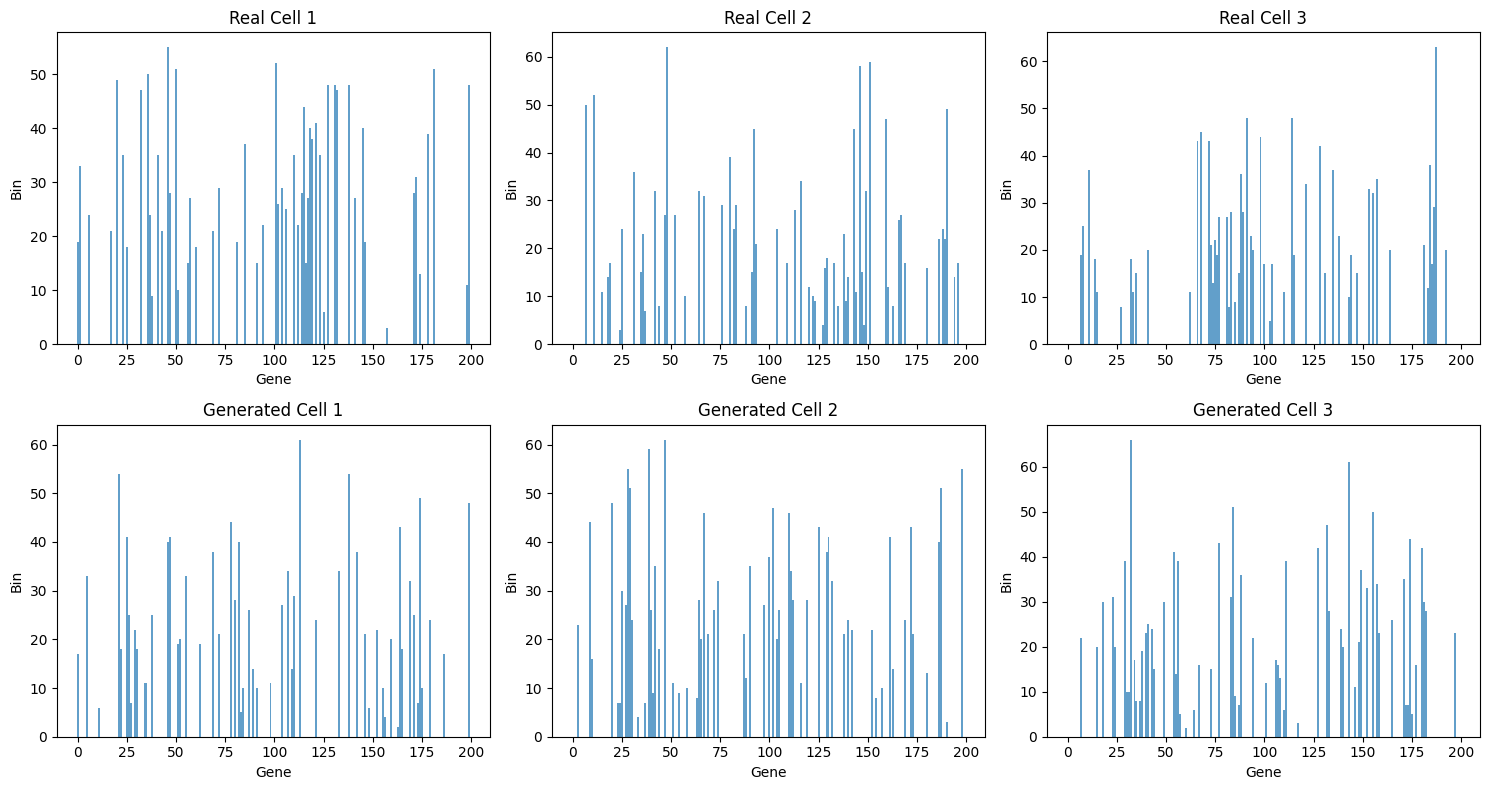

In [16]:
# Compare generated vs real cells
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot real cells
for i in range(3):
    axes[0, i].bar(range(NUM_GENES), test_batch[i].cpu().numpy(), alpha=0.7, width=1.0)
    axes[0, i].set_xlabel('Gene')
    axes[0, i].set_ylabel('Bin')
    axes[0, i].set_title(f'Real Cell {i+1}')

# Plot generated cells
for i in range(3):
    axes[1, i].bar(range(NUM_GENES), generated[i].cpu().numpy(), alpha=0.7, width=1.0)
    axes[1, i].set_xlabel('Gene')
    axes[1, i].set_ylabel('Bin')
    axes[1, i].set_title(f'Generated Cell {i+1}')

plt.tight_layout()
plt.show()

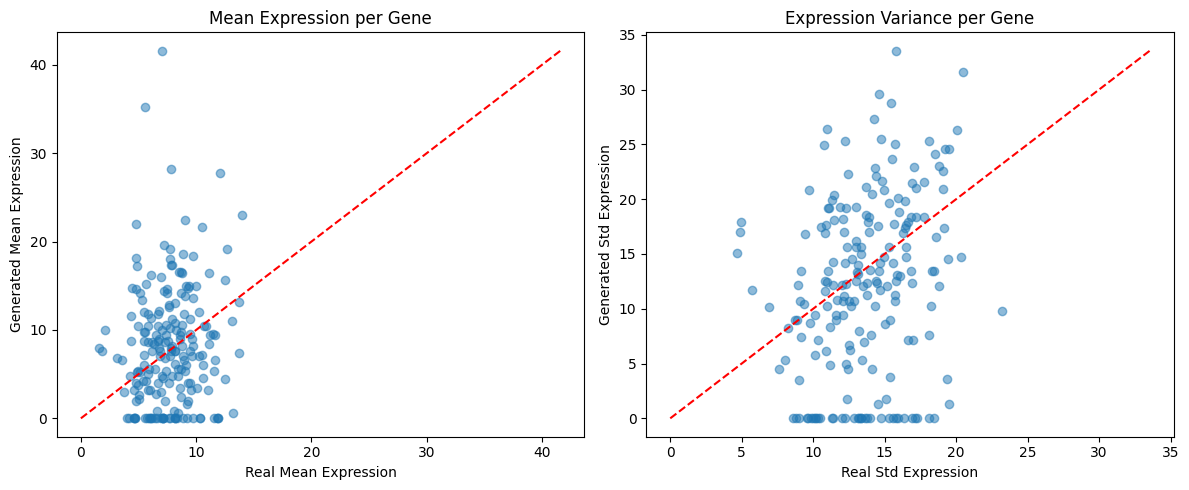

Mean expression correlation: 0.101


In [17]:
# Compare statistics
real_mean = test_batch.float().mean(dim=0).cpu().numpy()
gen_mean = generated.float().mean(dim=0).cpu().numpy()

real_std = test_batch.float().std(dim=0).cpu().numpy()
gen_std = generated.float().std(dim=0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(real_mean, gen_mean, alpha=0.5)
axes[0].plot([0, max(real_mean.max(), gen_mean.max())], 
             [0, max(real_mean.max(), gen_mean.max())], 'r--')
axes[0].set_xlabel('Real Mean Expression')
axes[0].set_ylabel('Generated Mean Expression')
axes[0].set_title('Mean Expression per Gene')

axes[1].scatter(real_std, gen_std, alpha=0.5)
axes[1].plot([0, max(real_std.max(), gen_std.max())], 
             [0, max(real_std.max(), gen_std.max())], 'r--')
axes[1].set_xlabel('Real Std Expression')
axes[1].set_ylabel('Generated Std Expression')
axes[1].set_title('Expression Variance per Gene')

plt.tight_layout()
plt.show()

# Correlation
mean_corr = np.corrcoef(real_mean, gen_mean)[0, 1]
print(f'Mean expression correlation: {mean_corr:.3f}')

## 8. Save and Load Model

Finally, let's save the trained model for later use.

In [18]:
import os

# Create checkpoints directory
os.makedirs('checkpoints', exist_ok=True)

# Save model
trainer.save_checkpoint('checkpoints/demo_model.pt')
print('Model saved to checkpoints/demo_model.pt')

Model saved to checkpoints/demo_model.pt


In [19]:
# Load model (demonstration)
# Create a new model instance
new_model = SEDDTransformerSmall(
    num_genes=NUM_GENES,
    num_bins=NUM_BINS,
    hidden_dim=128,
    num_layers=4,
    num_heads=4,
    dropout=0.1
).to(device)

new_trainer = SEDDTrainer(
    model=new_model,
    graph=graph,
    noise=noise,
    device=device
)

new_trainer.load_checkpoint('checkpoints/demo_model.pt')
print(f'Model loaded! Trained for {new_trainer.epoch + 1} epochs.')

Model loaded! Trained for 20 epochs.


## Summary

In this notebook, we demonstrated:

1. **Data preparation**: Creating and discretizing single-cell RNA-seq data
2. **Model setup**: Creating a SEDD transformer with absorbing diffusion
3. **Training**: Training the model to predict masked gene expression
4. **Imputation**: Using the trained model to fill in missing expression values
5. **Generation**: Generating novel cell expression profiles from scratch

### Tips for Better Results

- **Train longer**: Use more epochs (100+) for better imputation accuracy
- **Larger model**: Use SEDDTransformerMedium or SEDDTransformerLarge for larger datasets
- **More bins**: Increase num_bins for finer expression resolution
- **Tune mask ratio**: Experiment with different training mask ratios (0.1-0.3)
- **Lower temperature**: Use temperature < 1.0 for more confident predictions